<h1 align='center'>EE2703 Applied Programming Lab</h1>
<h2 align='center'>Assignment 5</h2>
<h3 align='center'>March 3, 2018</h3>
<h3 align='center'>Rajat Vadiraj Dwaraknath EE16B033</h3>

# Introduction
In this assignment, we analyze one method of numerically solving _Laplace's Equation_:

$$\nabla^2 \phi = 0$$

This equation is a special case of _Poisson's Equation_:

$$\nabla^2 \phi = f$$

Where $\phi(x,y)$ is a scalar function describing some potential, and $f(x,y)$ is a scalar function describing some source density. If there are no sources, Poisson's equation reduces to Laplace's equation.  

In this assignment, we look at one particular instance of Poisson's equation, which arises in electrostatics. The electrostatic potential $V$ is given by:

$$\nabla^2 V = -\frac{\rho}{\epsilon}$$

Where $\rho$ is the charge density and $\epsilon$ is the permittivity of free space. Given that there are no charges in the region of interest, it reduces to:

$$\nabla^2 V = 0$$

This equation involving contiuous partial derivatives is converted to a discrete difference equation in 2 dimensions using the central difference approximation for second derivatives. On manipulating that equation we arrive at the condition that the potential at any point is equal to the average of the potential of its neighbors. We use this fact to iteratively approach a solution, by replacing each point in our estimate of the potential by the average of its neighbors. This iterative process approaches the true solution, albeit extremely slowly. We analyse the rate at which the error decays as well, and estimate the total error by analytically integrating a fit of the estimated errors.

Note that, while solving Poisson's equation with non-zero sources, the averaging term also includes a contribution from the source component.

We then find the current density $\vec{J}$ in the region by using the following equations:

$$\vec{E} = -\nabla V$$
$$\vec{J} = \sigma \vec{E}$$

We look at a particular situation where a circular conducting electrode at a fixed potential of $1$ volt is connected to a 2 dimensional square plate. One of the sides of the plates is grounded to $0$ volts.

In [1]:
%%capture
# Importing numpy and matplotlib
%pylab inline 
from IPython.display import *

In [2]:
# Increase figure and font size
rcParams['figure.figsize'] = 12,9
rcParams['font.size'] = 18
rcParams['text.usetex'] = True

# Poisson solver
A general class to solve Poisson's equation on a domain given a source and certain boundary conditions is written below:

In [3]:
class PoissonSolver():
    def __init__(self, dirichletBndry, source=0, 
                 x_range=(-0.5,0.5), y_range=(-0.5,0.5),
                 xpoints=25,ypoints=25):
        
        """
        Solves Poisson's equation on the rectangular domain defined by
        x_range and y_range, given the Dirichlet boundary conditions.
        
        Implicitly assumes Neumann conditions on that part of the rectangular
        boundary which does not have any Dirichlet condition.
        
        The mesh is a grid of size xpoints x ypoints.
        """
        
        self.dirichletBndry = dirichletBndry
        self.source = source
        xx = linspace(*x_range,xpoints)
        yy = linspace(*y_range,ypoints)
        
        # The coordinates of the domain
        self.xdomain, self.ydomain = meshgrid(xx,yy)
        self.mesh = zeros(self.xdomain.shape)
        
    def laplaceIter(self):
        """
        Perform one iteration of averaging on the mesh.
        """
        mesh = self.mesh
        mesh[1:-1,1:-1] = 0.25*(
            mesh[2: ,1:-1]+
            mesh[:-2,1:-1]+
            mesh[1:-1,2:]+
            mesh[1:-1,:-2]+
            self.source)
        return mesh
    
    def enforceNeumann(self):
        """
        Enforce a Neumann condition of 0 derivative on all 4 boundaries
        of the rectangular domain.
        """
        mesh = self.mesh
        mesh[:,0]=mesh[:,1]
        mesh[:,-1]=mesh[:,-2]
        mesh[0,:]=mesh[1,:]
        mesh[-1,:]=mesh[-2,:]
        return mesh
    
    def enforceDirichlet(self):
        """
        Enforce the dirichlet conditions given by the condition instance.
        """
        # Indices of the boundary where the condition is enforced
        ii = where(self.dirichletBndry.boundary(self.xdomain,self.ydomain))
        
        # Value of the boundary function on the domain
        values = self.dirichletBndry.bndryVal(self.xdomain,self.ydomain)
        
        # Enforce the condition
        self.mesh[ii]=values[ii]
        return self.mesh
    
    def solve(self,steps):
        """
        Perform 'steps' number of iterations fo the averaging while enforcing 
        boundary conditions.
        
        Returns a list of consecutive errors between iterations. The error is 
        evaluated as the maximum of absolute deviation.
        """
        oldmesh = self.mesh.copy()
        self.enforceDirichlet()
        errors = []
        
        for i in range(steps):
            self.laplaceIter()
            self.enforceNeumann()
            self.enforceDirichlet()
            
            errors.append((abs(self.mesh-oldmesh)).max())
            oldmesh = self.mesh.copy()
        
        return errors

# Boundary conditions
The fixed boundary conditions are encapsulated into a class below:

In [4]:
class DirichletBoundary():
    def __init__(self,boundary,bndryVal):
        """
        The boundary curve and the boundary value are encapsulated into one
        object using this class.
        """
        self.boundary = boundary
        self.bndryVal = bndryVal

As we saw in the solver class defined above, the Neumann conditions are implicitly assumed on all boundary points where Dirichlet conditions are not applied.

We define the boundary curve function and the boundary value function for the electrode and grounding of one side of the plate below:

In [5]:
def circlePlate(i,j,centre=(0,0),radius=0.35,H=-0.5,eps=1e-10):
    """
    A function which returns which points lie inside a circle, 
    or on the bottom side of the plate.
    """
    i0,j0 = centre[0],centre[1]
    boo = (i-i0)*(i-i0)+(j-j0)*(j-j0) <= radius*radius
    return boo | (abs(j-H)<eps)

In [6]:
def circleVal(x,y,H=-0.5,eps=1e-10):
    """
    Returns a value of 1 for all points, except for the bottom plate,
    where it returns 0.
    """
    val = ones(x.shape)
    val[where(abs(y-H)<eps)] = 0
    return val

# The solution
The above classes are used to define a solver for our problem.

In [7]:
d = DirichletBoundary(circlePlate,circleVal)
p = PoissonSolver(d)

We plot the voltage contours after enforcing the dirichlet boundary conditions, before performing any iterations:

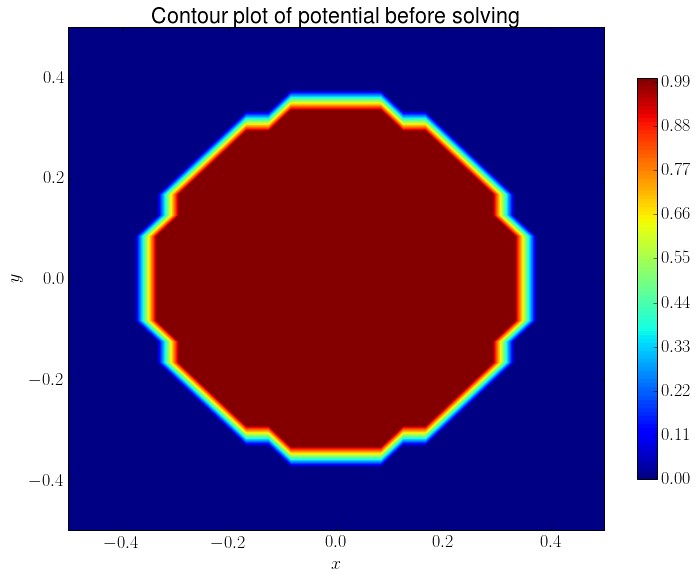

In [8]:
p.enforceDirichlet()
title("Contour plot of potential before solving")
xlabel("$x$")
ylabel("$y$")
CS = contourf(p.xdomain,p.ydomain,p.mesh,100)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
show()

We observe that the circular electrode appears quite polygonal. This is because of the low number of points in the grid(25x25).

Let us perform $1500$ averaging iterations and observe the results:

In [9]:
Niters = 1500
errs = p.solve(Niters)

The potential is plotted below:

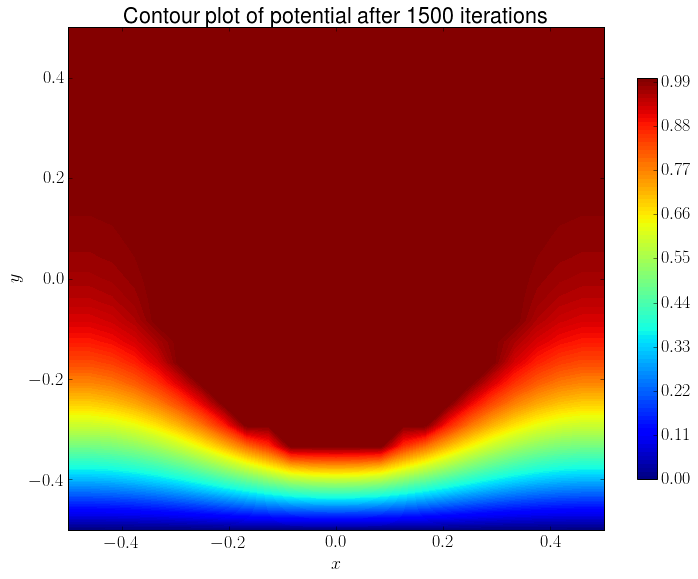

In [10]:
title("Contour plot of potential after 1500 iterations")
xlabel("$x$")
ylabel("$y$")
CS = contourf(p.xdomain,p.ydomain,p.mesh,100)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
show()

We observe that most of the potential drop occurs on the lower part of the plate while the upper part of the plate remains at almost a constant voltage of around $1$ volt. Let us repeat this with a larger grid, of say 100x100 points. Since the grid is larger, we will also need more number of iterations to reach the same level of accuracy, so $10^5$ iterations are used:

In [11]:
p2 = PoissonSolver(d,xpoints=100,ypoints=100)
e = p2.solve(10000)

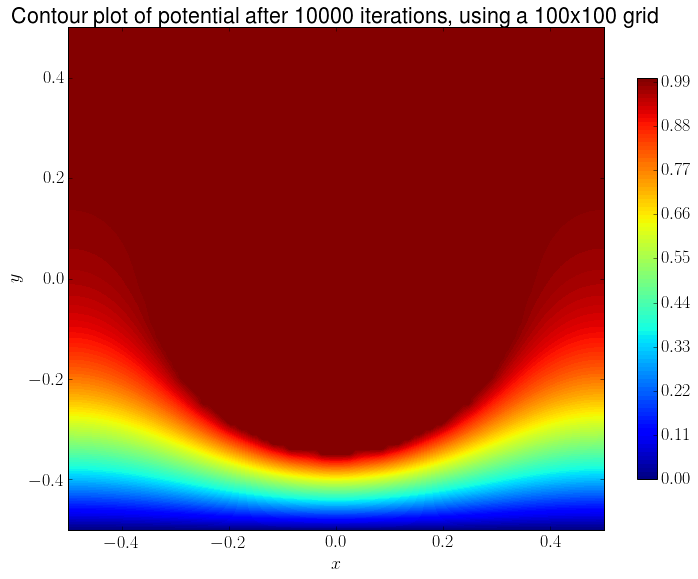

In [12]:
title("Contour plot of potential after 10000 iterations, using a 100x100 grid")
xlabel("$x$")
ylabel("$y$")
CS = contourf(p2.xdomain,p2.ydomain,p2.mesh,100)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
show()

The solution now appears much smoother, and we can see that it more or less resembles the solution for the 25x25 grid.

# Error analysis
Let us analyze the convergence of this iterative method. We plot the error at every 50th iteration on a semilog plot below:

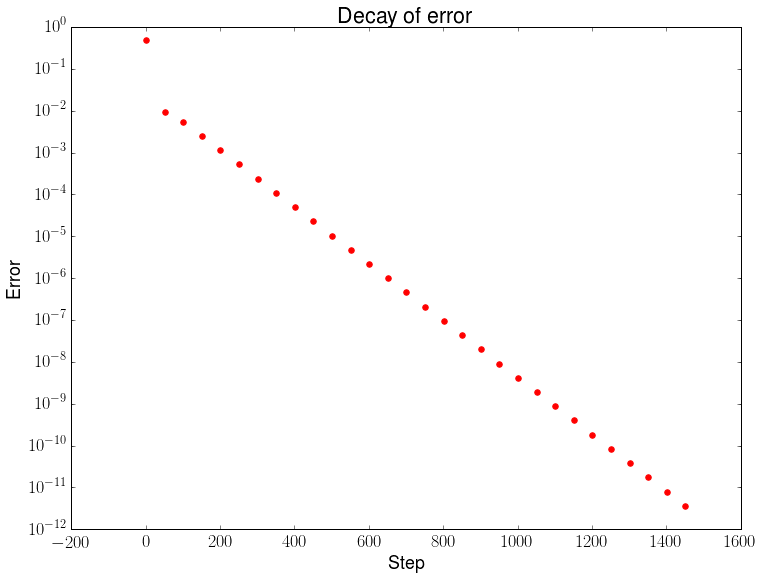

In [13]:
fig, ax = subplots(1,1)
ax.set_yscale('log')
N = arange(Niters)+1
ax.scatter(N[::50],errs[::50],color='red',s=30)
ax.set_ylabel("Error")
ax.set_xlabel("Step")
title("Decay of error")
show()

Since the semilog plot is linear for the later iterations, we can conclude that the consecutive error decays exponentially. We can use this knowledge to estimate the actual error by integrating a model for the consecutive error. From the above graph, a good model would be:

$$y = A e^{Bx}$$

We fit to this model by linearizing the relation:

$$\log y = \log A + Bx$$

We use least squares fitting to obtain the values for $A$ and $B$. We first perform the fit for all 1500 iterations:

In [14]:
M1 = stack((ones(Niters),N)).transpose()
A1,B1 = lstsq(M1,log(errs))[0]
A1 = exp(A1)
print(A1,B1)

0.0266291687904 -0.0156552606649


We also fit for all iterations after the first 500, as we see that the error does not decay exponentially in the inital iterations.

In [15]:
M2 = stack((ones(Niters)[500:],N[500:])).transpose()
A2,B2 = lstsq(M2,log(errs)[500:])[0]
A2 = exp(A2)
print(A2,B2)

0.0264545735233 -0.0156480620449


We plot the two fits along with the error below:

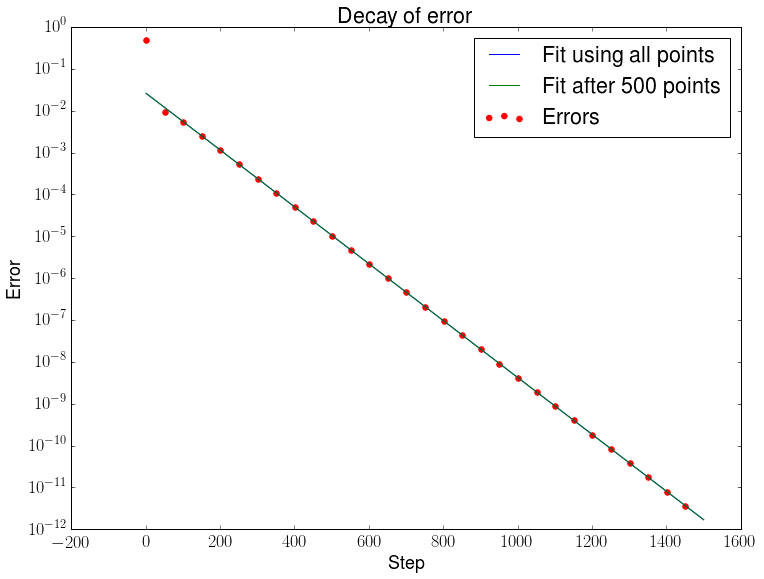

In [16]:
ax.plot(N,A1*exp(B1*N))
ax.plot(N,A2*exp(B2*N))
ax.legend(["Fit using all points", "Fit after 500 points","Errors"])
display(fig)

We use this model to estimate the total error by integrating the consecutive error. We obtain the following expression for the error after $N$ iterations:

$$Error = \frac{-A}{B} e^{B(N+0.5)}$$

We estimate this error for $1500$ iterations using the two fits below:

In [17]:
def integratedError(A,B,N):
    """
    Return the estimate of the total integrated error after N iterations
    given model parameters A and B.
    """
    return -A/B*exp(B*(N+0.5))

First fit (all points):

In [18]:
print("Estimated total error: {}\nFinal consecutive error: {}"
      .format(integratedError(A1,B1,Niters),errs[Niters-1]))

Estimated total error: 1.0685819434800071e-10
Final consecutive error: 1.6932011348558262e-12


Second fit (iterations >500)

In [19]:
print("Estimated total error: {}\nFinal consecutive error: {}"
      .format(integratedError(A2,B2,Niters),errs[Niters-1]))

Estimated total error: 1.073598197812038e-10
Final consecutive error: 1.6932011348558262e-12


We note from the above calculations that the consecutive error underestimates the total error by around $2$ orders of magnitude. This means that we cannot always trust the consecutive error as an error estimate, and we should use the calculated model parameters to find the total error and use that value to decide when to stop.

# Surface plot of potential
We make a surface plot of the potential below, using the 25x25 grid:

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

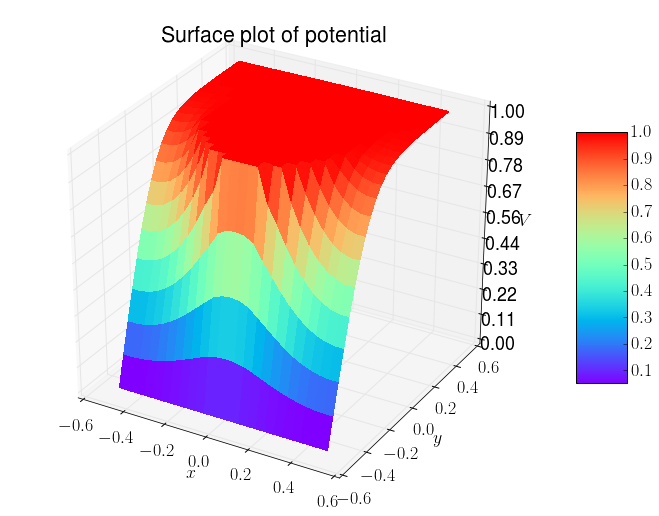

In [21]:
fig2 = figure()
ax2 = fig2.gca(projection='3d')
ax2.set_title("Surface plot of potential")
surf = ax2.plot_surface(p.xdomain,p.ydomain,p.mesh,cmap=cm.rainbow,
                       linewidth=0, antialiased=False,rstride=1,cstride=1)

ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y$")
ax2.set_zlabel("$V$")
fig2.colorbar(surf, shrink=0.5, aspect=5)
show()

We also plot it for the 100x100 grid below:

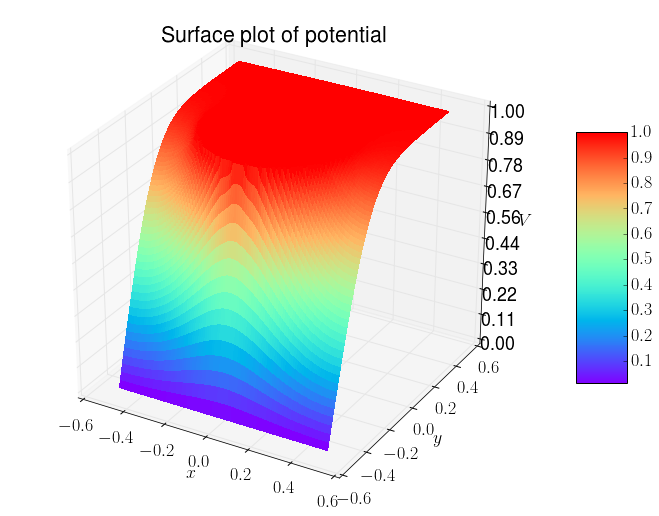

In [22]:
fig2 = figure()
ax2 = fig2.gca(projection='3d')
ax2.set_title("Surface plot of potential")
surf = ax2.plot_surface(p2.xdomain,p2.ydomain,p2.mesh,cmap=cm.rainbow,
                       linewidth=0, antialiased=False,rstride=1,cstride=1)

ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y$")
ax2.set_zlabel("$V$")
fig2.colorbar(surf, shrink=0.5, aspect=5)
show()

The gradation of the potential is now much clearer.

# Current calculations
The current density is calculated by finding the negative gradient of the potential field $V$, assuming that the plate has a conductivity of $\sigma = 1$.

In [23]:
def negGradient(a):
    """
    Find the negative gradient of the mesh 'a' using the midpoint approximation.
    """
    J_y = -0.5*(a[2:,1:-1]-a[0:-2,1:-1])
    J_x = -0.5*(a[1:-1,2:]-a[1:-1,0:-2])
    return J_x, J_y

In [24]:
J_x, J_y = negGradient(p.mesh)

A quiver plot of the current density for the 25x25 grid is shown below:

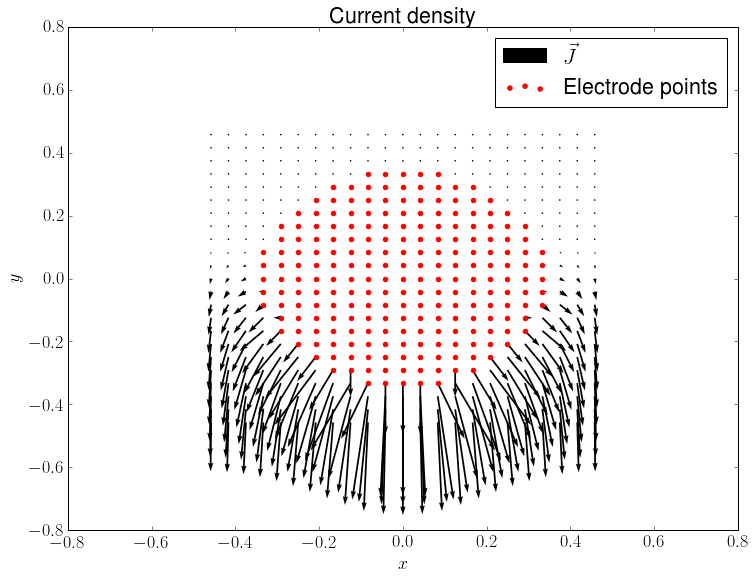

In [25]:
figure()
quiver(p.xdomain[1:-1,1:-1],p.ydomain[1:-1,1:-1],J_x,J_y)
scatter(p.xdomain[where(d.boundary(p.xdomain,p.ydomain) & ((p.ydomain+0.5)>1e-3))],
        p.ydomain[where(d.boundary(p.xdomain,p.ydomain) & ((p.ydomain+0.5)>1e-3))],color='red')

title("Current density")
xlabel("$x$")
ylabel("$y$")
ylim(-0.8,0.8)
xlim(-0.8,0.8)
legend([r"$\vec{J}$","Electrode points"])
show()

Similarly, for the 100x100 grid:

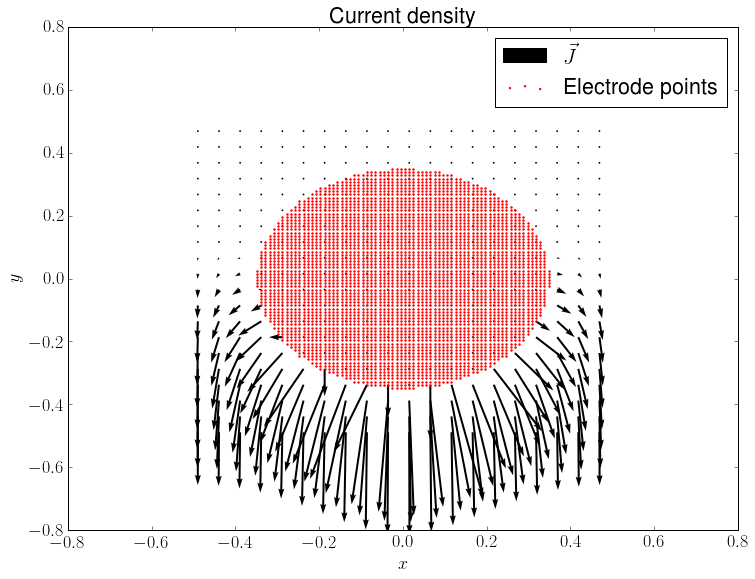

In [26]:
figure()
J2_x, J2_y = negGradient(p2.mesh)
skip = 5
quiver(p2.xdomain[1:-1:skip,1:-1:skip],p2.ydomain[1:-1:skip,1:-1:skip],
       J2_x[::skip,::skip],J2_y[::skip,::skip])
scatter(p2.xdomain[where(d.boundary(p2.xdomain,p2.ydomain) & ((p2.ydomain+0.5)>1e-3))],
        p2.ydomain[where(d.boundary(p2.xdomain,p2.ydomain) & ((p2.ydomain+0.5)>1e-3))],
        color='red',s=2)

title("Current density")
xlabel("$x$")
ylabel("$y$")
ylim(-0.8,0.8)
xlim(-0.8,0.8)
legend([r"$\vec{J}$","Electrode points"])
show()

We observe from the above plots that almost all of the current flows in the bottom half of the plate, while almost no current flows in the upper half. This occurs because the electrode and ground form a capacitor, where most of the electric field exists in the space directly between them. Therefore, most of the current will flow in that region, and so will most of the potential drop occur there.

# Heating of the plate
We solve the Laplace equation for heat flow:

$$\nabla^2 T = -\frac{q}{\kappa} = -\frac{|J|^2}{\sigma \kappa}$$

We again assume the electrical and thermal conductivites of the plate are $1$. We calculate the heat generated below:

In [27]:
heat_source = J_x*J_x + J_y*J_y

The boundary conditions for this case are $T = 300$ on the the electrode and the grounded side of the plate, and the normal derivative of temperature is $0$ on the other three sides. This is implemented below:

In [28]:
def tempBndryVal(x,y,H=-0.5,eps=1e-10):
    val = ones(x.shape)
    val[:,:]=300
    return val

The boundary condition object is created and associated with a solver:

In [29]:
tempCond = DirichletBoundary(circlePlate,tempBndryVal)
p3 = PoissonSolver(tempCond,source=heat_source)

We solve using $1500$ iterations again:

In [30]:
errs = p3.solve(Niters)

A contour plot of the temperature is shown below:

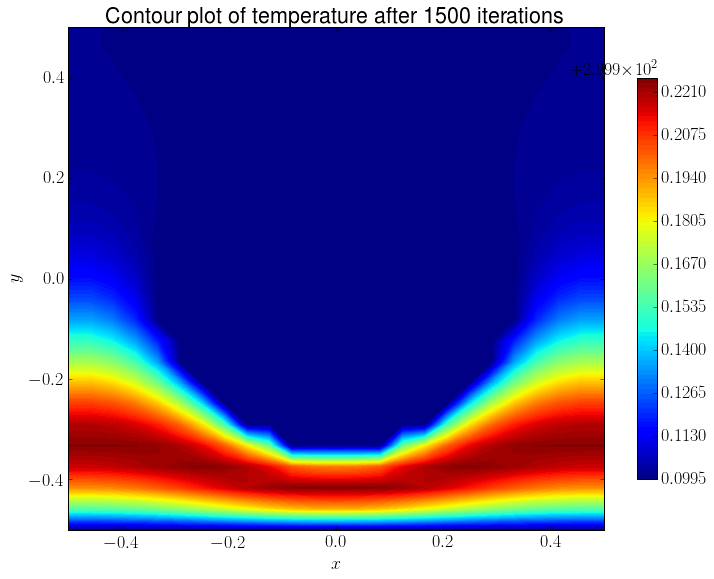

In [31]:
title("Contour plot of temperature after 1500 iterations")
xlabel("$x$")
ylabel("$y$")
CS = contourf(p3.xdomain,p3.ydomain,p3.mesh,100)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
show()

The above plot confirms our guess that most of the heating happens on the bottom part of the plate, where most of the current flows.

# Conclusions
* The averaging method of solving Laplace's or Poisson's equation is a simple numerical method, but is extremely slow.
* The consecutive error between iteration steps decays exponentially, and is also not a very accurate estimate for the total error.
* For the given case which was solved, we observed that most of the potential drop occured on the bottom half of the plate.
* This resulted in large electric fields in the bottom part, leading to most of the current flow in this part of the plate.
* This meant that most of the heating would probably occur in this part of the plate. 
* This was confirmed by solving Poisson's equation for steady state heat flow using the heat generated by the currents as the source term in the equation.